## Optax without Flax ? 

So in notebook number 07, I showed how you can train a simple linear regression model using jax. The whole optimisation process there was done manually. Although it was just an introduction, such manual optimisation isn't really recommended for larger projects. So continuing from notebook 08, what if you don't want to use flax, write everything from scratch using jax and now want to use optax? Let's use the same code from notebook 07 and replace the manual optimisation process with optax. 

In [1]:
import jax
import jax.numpy as jnp

masterkey = jax.random.PRNGKey(0)
masterkey, *subkeys = jax.random.split(masterkey, 10)



f = lambda x: 4 * x + 3
f(1)



xs = jax.random.normal(subkeys[0], shape=(1000, ))
ys = f(xs)




@jax.jit
def lin_reg_model(params, x):
    w, b = params
    
    y_pred = w * x + b
    return y_pred


def init_params():
    return jax.random.normal(subkeys[1], shape=(2, ))

params = init_params()


@jax.jit
def compute_loss(params, x, y):
    y_pred = lin_reg_model(params, x)
    
    # mse error
    error = jnp.mean((y - y_pred) ** 2)
    
    return error


## Enter the Optax

In [2]:
import optax

optimiser = optax.sgd(learning_rate=0.01)

Let's take a look at the previous `update` function from notebook 07. 

```python
@jax.jit
def update(params, x, y, lr=0.01): 
    # get loss value and also gradients
    values, grads = jax.value_and_grad(compute_loss)(params, x, y)
    
    updated_params = params - lr * grads
    # alternative
    # updated_params = jax.tree_map(lambda p, g: p - lr * g, params, grads)

    return values, updated_params

```

We no longer need the manual update. Optax will do that but we also have to pass in the optimiser and the initial optimiser state. Where's the problem with that? The `jit`. Optimisers aren't jit'able. So we have to rewrite the function a bit. Actually, let's just write one training function that takes in the data, optimiser and everything else and gives us trained params. (Funny that you're always training the params and not the model and yet we call it model training. xD) 

In [3]:
from tqdm.auto import trange


def train_model(params, x, y, optimiser, epochs=100):
    # create the initial optimiser state
    # well this way, every time train_model is called, the params are trained with a new optimiser state
    optimiser_state = optimiser.init(params)
    
    @jax.jit
    def update(params, x, y, optimiser_state): 
        # get loss value and also gradients
        values, grads = jax.value_and_grad(compute_loss)(params, x, y)
        # get updates
        updates, optimiser_state = optimiser.update(grads, optimiser_state, params)
        # now apply updates
        params = optax.apply_updates(params, updates)

        return values, params   
    
    
    

    epochs = 100

    losses = list() # keep a list to plot later


    for _ in trange(epochs):
        values, params = update(params, xs, ys, optimiser_state)
    
        # append the loss
        losses.append(values)
        
    
    return losses, params

In [4]:
losses, trained_params = train_model(params, xs, ys, optimiser)

  0%|          | 0/100 [00:00<?, ?it/s]

As usual, let's plot the losses and compare the actual and predicted function.

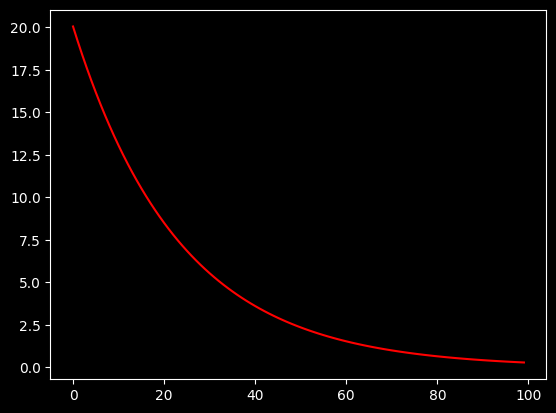

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.plot(jnp.arange(100), losses, c="r")

<function matplotlib.pyplot.legend(*args, **kwargs)>

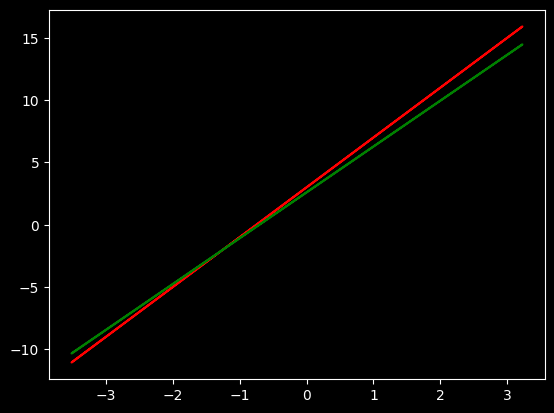

In [6]:
# actual vs predicted

plt.plot(xs, ys, c="r", label="actual")
plt.plot(xs, lin_reg_model(trained_params, xs), c="g", label="predicted")
plt.legend

So that's it. You now have an elementary understanding of a training loop using jax, (and or, flax) and optax. Let's recap a bit. You initialise your params, create the optimiser, initialise the optimiser states and then duing training, update the optimiser state and params using optax. 

Also: make sure to check what you can `jit` and what you can't. 